수동 정규화로 전체 코드 통일, val_size=0.2, OneCycleLR 스케줄러 사용

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install thop

In [ ]:
# -*- coding: utf-8 -*-
"""
Unified ELK + Sequential Cross-Attention + Temporal Prototype Attention Framework
Supports: UCI-HAR, WISDM, MHEALTH, PAMAP2 datasets
"""

import os, math, time, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from thop import profile
from sklearn.manifold import TSNE
import time

# ============================================================
# Dataset Loaders
# ============================================================

def create_sliding_windows(X, y, time_steps, step):
    """Create sliding window sequences"""
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X[i:i + time_steps]
        labels = y[i:i + time_steps]
        values, counts = np.unique(labels, return_counts=True)
        mode_label = values[np.argmax(counts)]
        Xs.append(v)
        ys.append(mode_label)
    return np.array(Xs), np.array(ys)


def load_uci_har(data_path, time_steps=128, step=64, test_size=0.2, val_size=0.2, random_state=42):
    """Load UCI-HAR dataset - Original method for maximum compatibility"""
    _UCI_CHANNELS = [
        ("Inertial Signals/total_acc_x_", "txt"),
        ("Inertial Signals/total_acc_y_", "txt"),
        ("Inertial Signals/total_acc_z_", "txt"),
        ("Inertial Signals/body_acc_x_", "txt"),
        ("Inertial Signals/body_acc_y_", "txt"),
        ("Inertial Signals/body_acc_z_", "txt"),
        ("Inertial Signals/body_gyro_x_", "txt"),
        ("Inertial Signals/body_gyro_y_", "txt"),
        ("Inertial Signals/body_gyro_z_", "txt"),
    ]

    def _load_split(root, split):
        split_dir = os.path.join(root, split)
        mats = []
        for base, ext in _UCI_CHANNELS:
            arr = np.loadtxt(os.path.join(split_dir, f"{base}{split}.{ext}"))
            mats.append(arr[:, None, :])
        X = np.concatenate(mats, axis=1).astype(np.float32)
        y = np.loadtxt(os.path.join(split_dir, f"y_{split}.txt")).astype(np.int64) - 1
        return X, y

    print(f"Loading UCI-HAR from: {data_path}")
    X_train_full, y_train_full = _load_split(data_path, "train")
    X_test, y_test = _load_split(data_path, "test")

    # Split train into train/val using same method as original
    train_indices, val_indices = train_test_split(
        np.arange(len(X_train_full)), test_size=val_size, random_state=random_state,
        stratify=y_train_full
    )

    X_train = X_train_full[train_indices]
    y_train = y_train_full[train_indices]
    X_val = X_train_full[val_indices]
    y_val = y_train_full[val_indices]

    # Original normalization method
    mu = X_train.mean(axis=(0, 2), keepdims=True)
    sd = X_train.std(axis=(0, 2), keepdims=True)
    sd[sd < 1e-6] = 1.0

    X_train = (X_train - mu) / sd
    X_val = (X_val - mu) / sd
    X_test = (X_test - mu) / sd

    class_names = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

    print(f"UCI-HAR loaded: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")
    return X_train, y_train, X_val, y_val, X_test, y_test, class_names


def load_wisdm(data_path, time_steps=200, step=40, test_size=0.2, val_size=0.2, random_state=42):
    """Load WISDM dataset with manual normalization"""
    print(f"Loading WISDM from: {data_path}")

    names = ["user", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
    data = pd.read_csv(data_path, header=None, names=names, comment=';')

    df = data.drop('NaN', axis=1).dropna()
    df["z_axis"] = df["z_axis"].replace(regex=True, to_replace=r';', value=r'')
    df["x_axis"] = df["x_axis"].astype('float32')
    df["y_axis"] = df["y_axis"].astype('float32')
    df["z_axis"] = df["z_axis"].astype('float32')

    label_encoder = LabelEncoder()
    df['activity_encoded'] = label_encoder.fit_transform(df['activity'])

    # Create windows
    X_all, y_all = create_sliding_windows(
        df[['x_axis', 'y_axis', 'z_axis']].values,
        df['activity_encoded'].values,
        time_steps, step
    )

    # Split
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_all, y_all, test_size=test_size, random_state=random_state, stratify=y_all
    )

    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, random_state=random_state, stratify=y_temp
    )

    # Manual normalization (similar to UCI-HAR)
    mu = X_train.mean(axis=(0, 1), keepdims=True)  # mean across samples and time
    sd = X_train.std(axis=(0, 1), keepdims=True)    # std across samples and time
    sd[sd < 1e-6] = 1.0

    X_train = (X_train - mu) / sd
    X_val = (X_val - mu) / sd
    X_test = (X_test - mu) / sd

    # Transpose to (samples, channels, time_steps)
    X_train = X_train.transpose(0, 2, 1)
    X_val = X_val.transpose(0, 2, 1)
    X_test = X_test.transpose(0, 2, 1)

    class_names = list(label_encoder.classes_)

    print(f"WISDM loaded: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")
    return X_train, y_train, X_val, y_val, X_test, y_test, class_names


def load_mhealth(data_path, time_steps=200, step=40, test_size=0.2, val_size=0.1, random_state=42):
    """Load MHEALTH dataset with manual normalization and train_test_split"""
    print(f"Loading MHEALTH from: {data_path}")

    col_names = [
        'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
        'ecg1', 'ecg2',
        'acc_left_ankle_x', 'acc_left_ankle_y', 'acc_left_ankle_z',
        'gyro_left_ankle_x', 'gyro_left_ankle_y', 'gyro_left_ankle_z',
        'magnet_left_ankle_x', 'magnet_left_ankle_y', 'magnet_left_ankle_z',
        'acc_right_arm_x', 'acc_right_arm_y', 'acc_right_arm_z',
        'gyro_right_arm_x', 'gyro_right_arm_y', 'gyro_right_arm_z',
        'magnet_right_arm_x', 'magnet_right_arm_y', 'magnet_right_arm_z',
        'label', 'subject'
    ]

    dfs = []
    for i in range(1, 11):
        path = os.path.join(data_path, f"mHealth_subject{i}.log")
        df_i = pd.read_csv(path, sep='\t', header=None)
        df_i['subject'] = i
        dfs.append(df_i)

    df = pd.concat(dfs, ignore_index=True)
    df = df.dropna(how='any', axis=0)
    df.columns = col_names

    # Remove label 0
    df = df[df.label != 0]
    df['label'] = df['label'] - 1  # Adjust to 0-11

    # Extract features and labels
    X = df.drop(['label', 'subject'], axis=1).values
    y = df['label'].values

    # Create windows from all data
    X_all, y_all = create_sliding_windows(X, y, time_steps, step)

    # Split using train_test_split
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_all, y_all, test_size=test_size, random_state=random_state, stratify=y_all
    )

    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, random_state=random_state, stratify=y_temp
    )

    # Manual normalization (similar to UCI-HAR)
    # Calculate mean and std from training data
    mu = X_train.mean(axis=(0, 1), keepdims=True)  # mean across samples and time
    sd = X_train.std(axis=(0, 1), keepdims=True)    # std across samples and time
    sd[sd < 1e-6] = 1.0

    # Apply normalization
    X_train = (X_train - mu) / sd
    X_val = (X_val - mu) / sd
    X_test = (X_test - mu) / sd

    # Transpose to (samples, channels, time_steps)
    X_train = X_train.transpose(0, 2, 1)
    X_val = X_val.transpose(0, 2, 1)
    X_test = X_test.transpose(0, 2, 1)

    class_names = [
        'Standing still', 'Sitting and relaxing', 'Lying down',
        'Walking', 'Climbing stairs', 'Waist bends forward',
        'Frontal elevation of arms', 'Knees bending (crouching)',
        'Cycling', 'Jogging', 'Running', 'Jump front & back'
    ]

    print(f"MHEALTH loaded: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")
    return X_train, y_train, X_val, y_val, X_test, y_test, class_names


def load_pamap2(data_path, time_steps=100, step=50, test_size=0.2, val_size=0.1, random_state=42):
    """Load PAMAP2 dataset with manual normalization"""
    print(f"Loading PAMAP2 from: {data_path}")

    df = pd.read_csv(data_path)

    # Drop unnecessary columns
    columns_to_drop = [
        'timestamp', 'heart_rate',
        'hand_temp', 'hand_acc_6g_x', 'hand_acc_6g_y', 'hand_acc_6g_z',
        'hand_orient_1', 'hand_orient_2', 'hand_orient_3', 'hand_orient_4',
        'chest_temp', 'chest_acc_6g_x', 'chest_acc_6g_y', 'chest_acc_6g_z',
        'chest_orient_1', 'chest_orient_2', 'chest_orient_3', 'chest_orient_4',
        'ankle_temp', 'ankle_acc_6g_x', 'ankle_acc_6g_y', 'ankle_acc_6g_z',
        'ankle_orient_1', 'ankle_orient_2', 'ankle_orient_3', 'ankle_orient_4'
    ]
    df = df.drop(columns=columns_to_drop)

    # Activity mapping
    activity_mapping = {
        1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6,
        12: 7, 13: 8, 16: 9, 17: 10, 24: 11
    }
    df = df[df['activityID'].isin(activity_mapping.keys())]

    # Handle NaN
    df_list = []
    for activity_id in df['activityID'].unique():
        activity_df = df[df['activityID'] == activity_id].copy()
        numeric_cols = activity_df.select_dtypes(exclude='object').columns
        activity_df[numeric_cols] = activity_df[numeric_cols].interpolate(method='linear')
        activity_df[numeric_cols] = activity_df[numeric_cols].ffill().bfill()
        df_list.append(activity_df)

    df_processed = pd.concat(df_list, ignore_index=True)

    # Extract features and labels
    X = df_processed.drop(columns=['activityID', 'subject']).values
    y = df_processed['activityID'].map(activity_mapping).values

    # Create windows
    X_all, y_all = create_sliding_windows(X, y, time_steps, step)

    # Split
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_all, y_all, test_size=test_size, random_state=random_state, stratify=y_all
    )

    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, random_state=random_state, stratify=y_temp
    )

    # Manual normalization (similar to UCI-HAR)
    mu = X_train.mean(axis=(0, 1), keepdims=True)  # mean across samples and time
    sd = X_train.std(axis=(0, 1), keepdims=True)    # std across samples and time
    sd[sd < 1e-6] = 1.0

    X_train = (X_train - mu) / sd
    X_val = (X_val - mu) / sd
    X_test = (X_test - mu) / sd

    # Transpose to (samples, channels, time_steps)
    X_train = X_train.transpose(0, 2, 1)
    X_val = X_val.transpose(0, 2, 1)
    X_test = X_test.transpose(0, 2, 1)

    class_names = [
        'lying', 'sitting', 'standing', 'walking', 'running', 'cycling',
        'Nordic walking', 'ascending stairs', 'descending stairs',
        'vacuum cleaning', 'ironing', 'rope jumping'
    ]

    print(f"PAMAP2 loaded: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")
    return X_train, y_train, X_val, y_val, X_test, y_test, class_names


# ============================================================
# Dataset Class
# ============================================================

class HARDataset(Dataset):
    def __init__(self, X, y):
        if X.ndim != 3:
            raise ValueError(f"Data needs to be 3D (samples, channels, sequence), got {X.shape}")
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ============================================================
# Model Components
# ============================================================

class ELKBlock(nn.Module):
    """Efficient Large Kernel Block with structural reparameterization"""
    def __init__(self, in_channels, out_channels,
                 kernel_large1=31, kernel_large2=29,
                 kernel_small1=5, kernel_small2=3,
                 deploy=False):
        super().__init__()
        self.deploy = deploy
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_large1 = kernel_large1
        self.kernel_large2 = kernel_large2
        self.kernel_small1 = kernel_small1
        self.kernel_small2 = kernel_small2

        padding_large1 = kernel_large1 // 2
        padding_large2 = kernel_large2 // 2
        padding_small1 = kernel_small1 // 2
        padding_small2 = kernel_small2 // 2

        if deploy:
            self.reparam_conv = nn.Conv1d(
                in_channels, in_channels, kernel_large1,
                padding=padding_large1, groups=in_channels, bias=True
            )
        else:
            self.dw_large1 = nn.Conv1d(
                in_channels, in_channels, kernel_large1,
                padding=padding_large1, groups=in_channels, bias=False
            )
            self.bn_large1 = nn.BatchNorm1d(in_channels)

            self.dw_large2 = nn.Conv1d(
                in_channels, in_channels, kernel_large2,
                padding=padding_large2, groups=in_channels, bias=False
            )
            self.bn_large2 = nn.BatchNorm1d(in_channels)

            self.dw_small1 = nn.Conv1d(
                in_channels, in_channels, kernel_small1,
                padding=padding_small1, groups=in_channels, bias=False
            )
            self.bn_small1 = nn.BatchNorm1d(in_channels)

            self.dw_small2 = nn.Conv1d(
                in_channels, in_channels, kernel_small2,
                padding=padding_small2, groups=in_channels, bias=False
            )
            self.bn_small2 = nn.BatchNorm1d(in_channels)

            self.bn_id = nn.BatchNorm1d(in_channels)

        self.pointwise = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm1d(out_channels),
        )
        self.activation = nn.GELU()

    def forward(self, x):
        if self.deploy:
            x = self.reparam_conv(x)
        else:
            x1 = self.bn_large1(self.dw_large1(x))
            x2 = self.bn_large2(self.dw_large2(x))
            x3 = self.bn_small1(self.dw_small1(x))
            x4 = self.bn_small2(self.dw_small2(x))
            x5 = self.bn_id(x)
            x = x1 + x2 + x3 + x4 + x5

        x = self.activation(x)
        return self.pointwise(x)

    def reparameterize(self):
        if self.deploy:
            return

        def _fuse(conv, bn):
            if conv is None:
                kernel = torch.zeros(
                    (self.in_channels, 1, self.kernel_large1),
                    dtype=bn.weight.dtype, device=bn.weight.device
                )
                center = self.kernel_large1 // 2
                kernel[:, 0, center] = 1.0
                conv_bias = torch.zeros(
                    self.in_channels, dtype=bn.weight.dtype, device=bn.weight.device
                )
            else:
                kernel = conv.weight
                conv_bias = torch.zeros(
                    self.in_channels, dtype=bn.weight.dtype, device=bn.weight.device
                )

            std = (bn.running_var + bn.eps).sqrt()
            gamma = bn.weight
            beta = bn.bias
            running_mean = bn.running_mean

            fused_weight = kernel * (gamma / std).reshape(-1, 1, 1)
            fused_bias = (gamma / std) * (conv_bias - running_mean) + beta

            return fused_weight, fused_bias

        w_l1, b_l1 = _fuse(self.dw_large1, self.bn_large1)
        w_l2, b_l2 = _fuse(self.dw_large2, self.bn_large2)
        w_s1, b_s1 = _fuse(self.dw_small1, self.bn_small1)
        w_s2, b_s2 = _fuse(self.dw_small2, self.bn_small2)
        w_id, b_id = _fuse(None, self.bn_id)

        pad_l2 = (self.kernel_large1 - self.kernel_large2) // 2
        w_l2 = F.pad(w_l2, (pad_l2, pad_l2))

        pad_s1 = (self.kernel_large1 - self.kernel_small1) // 2
        w_s1 = F.pad(w_s1, (pad_s1, pad_s1))

        pad_s2 = (self.kernel_large1 - self.kernel_small2) // 2
        w_s2 = F.pad(w_s2, (pad_s2, pad_s2))

        final_w = w_l1 + w_l2 + w_s1 + w_s2 + w_id
        final_b = b_l1 + b_l2 + b_s1 + b_s2 + b_id

        reparam_padding = self.kernel_large1 // 2
        self.reparam_conv = nn.Conv1d(
            self.in_channels, self.in_channels, self.kernel_large1,
            padding=reparam_padding, groups=self.in_channels, bias=True
        ).to(final_w.device)

        self.reparam_conv.weight.data = final_w
        self.reparam_conv.bias.data = final_b

        self.deploy = True
        for attr in ['dw_large1', 'bn_large1', 'dw_large2', 'bn_large2',
                     'dw_small1', 'bn_small1', 'dw_small2', 'bn_small2', 'bn_id']:
            if hasattr(self, attr):
                delattr(self, attr)


class ELKBackbone(nn.Module):
    """ELK Backbone built by stacking ELKBlocks"""
    def __init__(self, in_channels, d_model=128, num_layers=6,
                 kernel_large1=31, kernel_large2=29,
                 kernel_small1=5, kernel_small2=3,
                 dropout=0.1):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(in_channels, d_model, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(d_model),
            nn.GELU(),
        )

        layers = []
        for _ in range(num_layers):
            layers.append(ELKBlock(
                d_model, d_model,
                kernel_large1=kernel_large1,
                kernel_large2=kernel_large2,
                kernel_small1=kernel_small1,
                kernel_small2=kernel_small2
            ))
            layers.append(nn.Dropout(dropout))

        self.elk_layers = nn.Sequential(*layers)
        self.out_channels = d_model

    def forward(self, x):
        x = self.stem(x)
        x = self.elk_layers(x)
        return x


class RMSNorm(nn.Module):
    def __init__(self, d, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(d))

    def forward(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.g


class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads=4, dropout=0.1, temperature=1.0):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.temperature = temperature

        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)
        self.out_proj = nn.Linear(d_model, d_model, bias=False)

        self.dropout = nn.Dropout(dropout)
        self.scale = (self.head_dim * temperature) ** -0.5

    def forward(self, query, key, value, mask=None):
        B, Tq, D = query.shape
        _, Tkv, _ = key.shape

        Q = self.q_proj(query).view(B, Tq, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_proj(key).view(B, Tkv, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_proj(value).view(B, Tkv, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale

        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(1) == 0, float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        out = torch.matmul(attn_weights, V)
        out = out.transpose(1, 2).contiguous().view(B, Tq, D)

        return self.out_proj(out), attn_weights


class ImprovedSensorCrossAttention(nn.Module):
    def __init__(self, d_model, num_sensors, num_heads=4, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_sensors = num_sensors

        self.sensor_tokens = nn.Parameter(torch.randn(1, num_sensors, d_model) * 0.02)
        self.sensor_relation = nn.Linear(d_model, d_model)
        self.axis_tokens = nn.Parameter(torch.randn(1, 3, d_model) * 0.02)
        self.axis_projection = nn.Linear(d_model, d_model)

        self.sensor_sa = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.norm_s = RMSNorm(d_model)
        self.axis_sa = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.norm_a = RMSNorm(d_model)
        self.cross_attn = MultiHeadCrossAttention(d_model, num_heads, dropout)
        self.norm1 = RMSNorm(d_model)
        self.norm2 = RMSNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(4 * d_model, d_model), nn.Dropout(dropout),
        )

    def forward(self, x):
        B, T, D = x.shape

        # Sensor context
        sensor_ctx = self.sensor_tokens.expand(B, -1, -1)
        x_pooled = x.mean(dim=1, keepdim=True)
        sensor_ctx = sensor_ctx + self.sensor_relation(x_pooled)
        s_norm = self.norm_s(sensor_ctx)
        s_attn, _ = self.sensor_sa(s_norm, s_norm, s_norm)
        sensor_ctx = sensor_ctx + s_attn

        # Axis averaging (generic for different sensor counts)
        num_axes = 3  # x, y, z
        if self.num_sensors % num_axes == 0:
            axes_data = []
            sensors_per_axis = self.num_sensors // num_axes
            for axis_idx in range(num_axes):
                axis_indices = list(range(axis_idx, self.num_sensors, num_axes))
                axis_mean = x[:, :, axis_indices].mean(dim=-1)
                axes_data.append(axis_mean)
            axis_stack = torch.stack(axes_data, dim=2)  # [B, T, 3]
        else:
            # Fallback: simple mean pooling
            axis_stack = x[:, :, :3] if self.num_sensors >= 3 else x.mean(dim=2, keepdim=True).repeat(1, 1, 3)

        axis_feat = axis_stack.mean(dim=1)  # [B, 3]
        axis_feat = axis_feat.unsqueeze(-1).repeat(1, 1, self.d_model)  # [B, 3, D]

        axis_ctx = self.axis_tokens.expand(B, -1, -1)
        axis_ctx = axis_ctx + self.axis_projection(axis_feat)
        a_norm = self.norm_a(axis_ctx)
        a_attn, _ = self.axis_sa(a_norm, a_norm, a_norm)
        axis_ctx = axis_ctx + a_attn

        # Cross attention
        combined_ctx = torch.cat([sensor_ctx, axis_ctx], dim=1)
        residual = x
        x_norm = self.norm1(x)
        attn_out, _ = self.cross_attn(x_norm, combined_ctx, combined_ctx)
        x = residual + attn_out
        x = x + self.ffn(self.norm2(x))

        return x


class TemporalCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads=4, dropout=0.1, causal=False):
        super().__init__()
        self.cross_attn = MultiHeadCrossAttention(d_model, num_heads, dropout)
        self.norm1 = RMSNorm(d_model)
        self.norm2 = RMSNorm(d_model)
        self.causal = causal
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(4 * d_model, d_model), nn.Dropout(dropout),
        )

    def _create_causal_mask(self, T, device):
        return torch.tril(torch.ones(T, T, device=device))

    def forward(self, x):
        B, T, D = x.shape
        mask = self._create_causal_mask(T, x.device) if self.causal else None
        residual = x
        x_norm = self.norm1(x)
        attn_out, _ = self.cross_attn(x_norm, x_norm, x_norm, mask)
        x = residual + attn_out
        x = x + self.ffn(self.norm2(x))
        return x


class SequentialCrossAttention(nn.Module):
    def __init__(self, d_model, num_sensors, num_heads=4, dropout=0.1):
        super().__init__()
        self.sensor_attn = ImprovedSensorCrossAttention(d_model, num_sensors, num_heads, dropout)
        self.temporal_attn = TemporalCrossAttention(d_model, num_heads, dropout, causal=False)

    def forward(self, x):
        x = self.sensor_attn(x)
        x = self.temporal_attn(x)
        return x


class TemporalPrototypeAttention(nn.Module):
    def __init__(self, dim, num_prototypes=16, seg_kernel=9, heads=4, dropout=0.1):
        super().__init__()
        assert dim % heads == 0
        self.dim, self.heads, self.head_dim = dim, heads, dim // heads
        self.num_prototypes = num_prototypes
        self.proto = nn.Parameter(torch.randn(num_prototypes, dim) * 0.02)
        pad = (seg_kernel - 1) // 2
        self.dw = nn.Conv1d(dim, dim, kernel_size=seg_kernel, padding=pad, groups=dim, bias=False)
        self.pw = nn.Conv1d(dim, dim, kernel_size=1, bias=False)
        self.q_proj, self.k_proj, self.v_proj, self.out_proj = [nn.Linear(dim, dim, bias=False) for _ in range(4)]
        self.fuse = nn.Sequential(nn.Linear(dim, dim), nn.SiLU(), nn.Dropout(dropout), nn.Linear(dim, dim))
        self.dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5

    def _tpa_core(self, x, proto):
        B, T, D = x.shape
        P = proto.size(1) if proto.dim() == 3 else proto.size(0)
        xloc = self.pw(self.dw(x.transpose(1, 2))).transpose(1, 2)
        K, V = self.k_proj(xloc), self.v_proj(xloc)
        Qp = self.q_proj(proto) if proto.dim() == 3 else self.q_proj(proto).unsqueeze(0).expand(B, -1, -1)

        def split_heads(t, is_kv=False):
            shape = (B, T if is_kv else P, self.heads, D // self.heads)
            return t.view(*shape).transpose(1, 2)

        Qh, Kh, Vh = split_heads(Qp, False), split_heads(K, True), split_heads(V, True)
        scores = torch.matmul(Qh, Kh.transpose(-2, -1)) * self.scale
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        proto_tokens = torch.matmul(attn, Vh).transpose(1, 2).contiguous().view(B, P, D)
        z = self.fuse(proto_tokens.mean(dim=1) + proto_tokens.max(dim=1).values)
        z = self.out_proj(z)
        aux = {"attn": attn, "align_peak_mean": attn.amax(dim=-1).mean().detach()}
        return z, aux

    def forward(self, x):
        return self._tpa_core(x, self.proto)


class ClassConditionalTPA(TemporalPrototypeAttention):
    def __init__(self, dim, num_classes, p_shared=6, p_class=4, **kw):
        super().__init__(dim, num_prototypes=p_shared + num_classes * p_class, **kw)
        self.p_shared, self.p_class, self.num_classes = p_shared, p_class, num_classes

    def _slice_class(self, cls_idx):
        base = self.p_shared + cls_idx * self.p_class
        return self.proto[base: base + self.p_class]

    def forward(self, x, y=None, logits=None):
        B = x.size(0)
        shared = self.proto[:self.p_shared]
        if self.training and y is not None:
            cls_proto = torch.stack([self._slice_class(y[i].item()) for i in range(B)], 0)
            proto = torch.cat([shared.unsqueeze(0).expand(B, -1, -1), cls_proto], dim=1)
        else:
            if logits is None:
                proto = shared.unsqueeze(0).expand(B, -1, -1)
            else:
                pi = logits.softmax(dim=-1)
                class_bank = torch.stack([self._slice_class(c) for c in range(self.num_classes)], 0)
                mixed = torch.einsum('bc,cpd->bpd', pi, class_bank)
                proto = torch.cat([shared.unsqueeze(0).expand(B, -1, -1), mixed], dim=1)
        return self._tpa_core(x, proto)


class ImprovedClsLoss(nn.Module):
    def __init__(self, use_focal=True, alpha=0.25, gamma=2.0, init_loss_weight=0.4, label_smoothing=0.1):
        super().__init__()
        self.use_focal, self.alpha, self.gamma = use_focal, alpha, gamma
        self.init_loss_weight, self.label_smoothing = init_loss_weight, label_smoothing

    def forward(self, logits, labels, aux_info, aux_weight_multiplier=1.0):
        n_classes = logits.size(-1)
        if self.label_smoothing > 0:
            one_hot = F.one_hot(labels, num_classes=n_classes).float()
            smooth_label = one_hot * (1 - self.label_smoothing) + self.label_smoothing / n_classes
            if self.use_focal:
                log_probs = F.log_softmax(logits, dim=-1)
                pt = torch.exp(log_probs)
                focal_weight = (1 - pt) ** self.gamma
                loss = -(self.alpha * focal_weight * smooth_label * log_probs).sum(dim=-1).mean()
            else:
                loss = -(smooth_label * F.log_softmax(logits, dim=-1)).sum(dim=-1).mean()
        else:
            ce = F.cross_entropy(logits, labels, reduction="none")
            if self.use_focal:
                pt = torch.exp(-ce)
                loss = (self.alpha * (1 - pt)**self.gamma * ce).mean()
            else:
                loss = ce.mean()

        total_loss = loss
        if "logits_init" in aux_info:
            loss_init = F.cross_entropy(aux_info["logits_init"], labels)
            total_loss = loss + self.init_loss_weight * loss_init

        return total_loss, {
            "classification_loss": float(loss.item()),
            "total_loss": float(total_loss.item()),
            "align_peak_mean": float(aux_info.get("align_peak_mean", 0.)),
        }


class ELK_SequentialAttn_TPA(nn.Module):
    def __init__(self, nvars, seq_len, num_classes,
                 num_elk_layers, elk_kernel_large1, elk_kernel_large2,
                 elk_kernel_small1, elk_kernel_small2,
                 d_model, heads, dropout,
                 num_prototypes, seg_kernel, p_shared, p_class,
                 use_class_conditional, use_cross_attention):
        super().__init__()
        self.use_class_conditional = use_class_conditional
        self.use_cross_attention = use_cross_attention

        self.backbone = ELKBackbone(
            in_channels=nvars,
            d_model=d_model,
            num_layers=num_elk_layers,
            kernel_large1=elk_kernel_large1,
            kernel_large2=elk_kernel_large2,
            kernel_small1=elk_kernel_small1,
            kernel_small2=elk_kernel_small2,
            dropout=dropout
        )

        self.proj = nn.Conv1d(self.backbone.out_channels, d_model, kernel_size=1)

        if use_cross_attention:
            self.cross_attn = SequentialCrossAttention(
                d_model, nvars, num_heads=heads, dropout=dropout
            )

        if use_class_conditional:
            self.tpa = ClassConditionalTPA(
                d_model, num_classes, p_shared, p_class,
                seg_kernel=seg_kernel, heads=heads, dropout=dropout
            )
        else:
            self.tpa = TemporalPrototypeAttention(
                d_model, num_prototypes, seg_kernel, heads, dropout
            )

        self.head_init = nn.Linear(d_model, num_classes)
        self.head_final = nn.Linear(d_model, num_classes)

    def forward(self, x, labels=None, return_features=False):
        x = self.backbone(x)
        x = self.proj(x)
        x = x.transpose(1, 2)
        x_pooled = x.mean(dim=1)
        logits_init = self.head_init(x_pooled)

        if self.use_cross_attention:
            x = self.cross_attn(x)

        if self.use_class_conditional:
            z, aux = self.tpa(x, y=labels, logits=logits_init)
        else:
            z, aux = self.tpa(x)

        logits_final = self.head_final(z)
        aux['logits_init'] = logits_init

        if return_features:
            return logits_final, aux, z
        else:
            return logits_final, aux

    def reparameterize(self):
        """Reparameterize all ELK blocks for inference"""
        for m in self.modules():
            if isinstance(m, ELKBlock):
                m.reparameterize()


# ============================================================
# Training & Evaluation
# ============================================================

def train_epoch(model, loader, criterion, optim, scheduler, device, accumulation_steps=4):
    model.train()
    tot, correct, total = 0.0, 0, 0
    optim.zero_grad()
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        logits, aux = model(x, labels=y)
        loss, _ = criterion(logits, y, aux, 1.0)
        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0 or i == len(loader) - 1:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()
            if scheduler: scheduler.step()
            optim.zero_grad()

        tot += loss.item() * accumulation_steps
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return tot / len(loader), 100 * correct / total


@torch.no_grad()
def extract_features(model, dataloader, device):
    """Extract features and labels for t-SNE visualization"""
    model.eval()
    features_list = []
    labels_list = []

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            _, _, features = model(data, labels, return_features=True)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    tot, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits, aux = model(x, labels=None)
        loss, _ = criterion(logits, y, aux, 1.0)
        tot += loss.item()
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return tot / len(loader), 100 * correct / total


@torch.no_grad()
def get_predictions(model, loader, device):
    """Get predictions and labels for metrics"""
    model.eval()
    all_preds, all_labels = [], []
    start_time = time.time()

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits, _ = model(x, labels=None)
        preds = logits.argmax(1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())

    end_time = time.time()
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    acc = (y_pred == y_true).mean() * 100.0
    inference_time = (end_time - start_time) / len(y_true) * 1000

    metrics = {
        "accuracy": acc, "f1": f1, "recall": recall,
        "precision": precision, "inference_time": inference_time
    }
    return y_pred, y_true, metrics


# ============================================================
# Visualization
# ============================================================

def plot_training_history(history, save_path='training_history.png'):
    """Plot training and validation loss/accuracy"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(history['train_loss'], 'r-', label='Train Loss', linewidth=2)
    axes[0].plot(history['val_loss'], 'b-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history['train_acc'], 'r-', label='Train Acc', linewidth=2)
    axes[1].plot(history['val_acc'], 'b-', label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Training history saved to {save_path}")


def plot_confusion_matrix(y_true, y_pred, class_names, save_path='confusion_matrix.png'):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Confusion matrix saved to {save_path}")


def plot_tsne(features_before, labels_before, features_after, labels_after,
              class_names, save_path='tsne_comparison.png'):
    """Plot t-SNE visualization before and after training"""
    print("Computing t-SNE embeddings...")

    # Before training
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    embedded_before = tsne.fit_transform(features_before)

    # After training
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    embedded_after = tsne.fit_transform(features_after)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Before training
    for i, class_name in enumerate(class_names):
        mask = labels_before == i
        axes[0].scatter(embedded_before[mask, 0], embedded_before[mask, 1],
                       label=class_name, alpha=0.6, s=30)
    axes[0].set_title('t-SNE: Before Training')
    axes[0].grid(True, alpha=0.3)

    # After training
    for i, class_name in enumerate(class_names):
        mask = labels_after == i
        axes[1].scatter(embedded_after[mask, 0], embedded_after[mask, 1],
                       label=class_name, alpha=0.6, s=30)
    axes[1].set_title('t-SNE: After Training')
    axes[1].grid(True, alpha=0.3)

    # Legend on the right side of the second plot
    axes[1].legend(loc='upper right', bbox_to_anchor=(1.35, 1.0),
                  fontsize=9, frameon=True, fancybox=False,
                  shadow=False, ncol=1)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"t-SNE visualization saved to {save_path}")


def get_model_stats(model, sample_input):
    """Calculate model parameters and FLOPs"""
    macs, params = profile(model, inputs=(sample_input,), verbose=False)
    return params / 1e6, macs / 1e6


# ============================================================
# Main Function
# ============================================================

def main(dataset='mhealth', data_path=None,
         time_steps=None, step=None,
         d_model=128, num_elk_layers=2,
         elk_kernel_large1=31, elk_kernel_large2=29,
         elk_kernel_small1=5, elk_kernel_small2=3,
         heads=8, dropout=0.2, seg_kernel=3,
         p_shared=6, p_class=4,
         use_class_conditional=True, use_cross_attention=True,
         batch_size=64, accumulation_steps=2,
         max_epochs=100, lr=5e-4, weight_decay=0.05,
         patience=20, seed=42):
    """
    Main training function

    Args:
        dataset: Dataset name ('uci', 'wisdm', 'mhealth', 'pamap2')
        data_path: Path to dataset
        time_steps: Window size (auto if None)
        step: Sliding step (auto if None)
        d_model: Model dimension
        num_elk_layers: Number of ELK layers
        elk_kernel_large1: Large kernel size 1
        elk_kernel_large2: Large kernel size 2
        elk_kernel_small1: Small kernel size 1
        elk_kernel_small2: Small kernel size 2
        heads: Number of attention heads
        dropout: Dropout rate
        seg_kernel: Segmentation kernel for TPA
        p_shared: Number of shared prototypes
        p_class: Number of class-specific prototypes
        use_class_conditional: Use class-conditional TPA
        use_cross_attention: Use cross-attention
        batch_size: Batch size
        accumulation_steps: Gradient accumulation steps
        max_epochs: Maximum epochs
        lr: Learning rate
        weight_decay: Weight decay
        patience: Early stopping patience
        seed: Random seed
    """

    # Set seeds
    torch.manual_seed(seed)
    np.random.seed(seed)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # Dataset-specific defaults
    dataset_configs = {
        'uci': {'time_steps': 128, 'step': 64, 'nvars': 9},
        'wisdm': {'time_steps': 200, 'step': 40, 'nvars': 3},
        'mhealth': {'time_steps': 200, 'step': 40, 'nvars': 23},
        'pamap2': {'time_steps': 100, 'step': 50, 'nvars': 27}
    }

    if dataset not in dataset_configs:
        raise ValueError(f"Dataset must be one of {list(dataset_configs.keys())}")

    if data_path is None:
        raise ValueError("data_path must be provided")

    config = dataset_configs[dataset]
    time_steps = time_steps if time_steps else config['time_steps']
    step = step if step else config['step']
    nvars = config['nvars']

    # Load dataset
    print(f"\n{'='*70}")
    print(f"Loading {dataset.upper()} dataset")
    print(f"{'='*70}")

    if dataset == 'uci':
        X_train, y_train, X_val, y_val, X_test, y_test, class_names = load_uci_har(
            data_path, time_steps, step
        )
    elif dataset == 'wisdm':
        X_train, y_train, X_val, y_val, X_test, y_test, class_names = load_wisdm(
            data_path, time_steps, step
        )
    elif dataset == 'mhealth':
        X_train, y_train, X_val, y_val, X_test, y_test, class_names = load_mhealth(
            data_path, time_steps, step
        )
    elif dataset == 'pamap2':
        X_train, y_train, X_val, y_val, X_test, y_test, class_names = load_pamap2(
            data_path, time_steps, step
        )

    num_classes = len(class_names)
    print(f"\nClasses ({num_classes}): {class_names}")
    print(f"Data shape: {X_train.shape}")

    # Create datasets
    train_ds = HARDataset(X_train, y_train)
    val_ds = HARDataset(X_val, y_val)
    test_ds = HARDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size*2, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size*2, shuffle=False, num_workers=2, pin_memory=True)

    # Create model
    model = ELK_SequentialAttn_TPA(
        nvars=nvars,
        seq_len=time_steps,
        num_classes=num_classes,
        d_model=d_model,
        heads=heads,
        dropout=dropout,
        num_elk_layers=num_elk_layers,
        elk_kernel_large1=elk_kernel_large1,
        elk_kernel_large2=elk_kernel_large2,
        elk_kernel_small1=elk_kernel_small1,
        elk_kernel_small2=elk_kernel_small2,
        num_prototypes=p_shared + num_classes * p_class,
        seg_kernel=seg_kernel,
        p_shared=p_shared,
        p_class=p_class,
        use_class_conditional=use_class_conditional,
        use_cross_attention=use_cross_attention
    ).to(device)

    # Extract features before training
    print("\nExtracting features before training...")
    features_before, labels_before = extract_features(model, test_loader, device)

    # Loss and optimizer
    criterion = ImprovedClsLoss(use_focal=True, alpha=0.25, gamma=2.0, init_loss_weight=0.4, label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    total_steps = (len(train_loader) // accumulation_steps) * max_epochs
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=2e-3, total_steps=total_steps, pct_start=0.2
    )

    # Training loop
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_epoch = 0
    patience_counter = 0

    print(f"\n{'='*70}")
    print(f"Starting training for {max_epochs} epochs")
    print(f"{'='*70}")
    print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Train Acc':>9} | {'Val Loss':>8} | {'Val Acc':>7} | {'Best':>7}")
    print(f"{'-'*70}")

    for epoch in range(1, max_epochs + 1):
        tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device, accumulation_steps)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"{epoch:5d} | {tr_loss:10.4f} | {tr_acc:8.2f}% | {val_loss:8.4f} | {val_acc:6.2f}% | {best_val_acc:6.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            torch.save(model.state_dict(), f'best_model_{dataset}.pth')
            print(f"      → New best: {best_val_acc:.2f}% (saved)")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch}")
                break

    print(f"\nTraining completed! Best val acc: {best_val_acc:.2f}% at epoch {best_epoch}")

    # Plot history
    plot_training_history(history, f'{dataset}_training_history.png')

    # Load best model and evaluate
    print(f"\n{'='*70}")
    print("FINAL TEST EVALUATION")
    print(f"{'='*70}")
    model.load_state_dict(torch.load(f'best_model_{dataset}.pth'))
    model.reparameterize()

    y_pred, y_true, metrics = get_predictions(model, test_loader, device)

    # Model stats
    sample_data, _ = next(iter(test_loader))
    params_M, macs_M = get_model_stats(model, sample_data.to(device))

    # Reports
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    plot_confusion_matrix(y_true, y_pred, class_names, f'{dataset}_confusion_matrix.png')

    # Extract features after training
    print("\nExtracting features after training...")
    features_after, labels_after = extract_features(model, test_loader, device)

    # t-SNE visualization
    plot_tsne(features_before, labels_before, features_after, labels_after, class_names, f'{dataset}_tsne_comparison.png')

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Summary
    print(f"\n{'='*70}")
    print("PERFORMANCE SUMMARY")
    print(f"{'='*70}")
    print(f"{'Test Accuracy (%)':<25} {metrics['accuracy']:<15.2f}")
    print(f"{'F1 Score (Macro)':<25} {metrics['f1']:<15.4f}")
    print(f"{'Recall (Macro)':<25} {metrics['recall']:<15.4f}")
    print(f"{'Precision (Macro)':<25} {metrics['precision']:<15.4f}")
    print(f"{'Parameters (M)':<25} {params_M:<15.4f}")
    print(f"{'MACs (M)':<25} {macs_M:<15.4f}")
    print(f"{'FLOPs (M)':<25} {macs_M * 2:<15.4f}")
    print(f"{'Inference Time (ms)':<25} {metrics['inference_time']:<15.2f}")
    print(f"\nModel parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"{'Best Val Acc (%)':<25} {best_val_acc:<15.2f}")
    print(f"{'Best Epoch':<25} {best_epoch:<15}")
    print(f"{'='*70}")

    return model, history, metrics

Device: cuda

Loading WISDM dataset
Loading WISDM from: /content/drive/MyDrive/AI_data/WISDM_ar_v1.1_raw.txt
WISDM loaded: Train=16470, Val=5490, Test=5491

Classes (6): ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
Data shape: (16470, 3, 200)

Extracting features before training...

Starting training for 100 epochs
Epoch | Train Loss | Train Acc | Val Loss | Val Acc |    Best
----------------------------------------------------------------------
    1 |     0.3886 |    77.18% |   0.2968 |  82.37% |   0.00%
      → New best: 82.37% (saved)
    2 |     0.2135 |    90.10% |   0.1542 |  94.32% |  82.37%
      → New best: 94.32% (saved)
    3 |     0.1272 |    99.65% |   0.1305 |  95.72% |  94.32%
      → New best: 95.72% (saved)
    4 |     0.1045 |    99.91% |   0.1120 |  96.70% |  95.72%
      → New best: 96.70% (saved)
    5 |     0.0973 |    99.99% |   0.1046 |  97.27% |  96.70%
      → New best: 97.27% (saved)
    6 |     0.0900 |   100.00% |   0.0996 |  97.

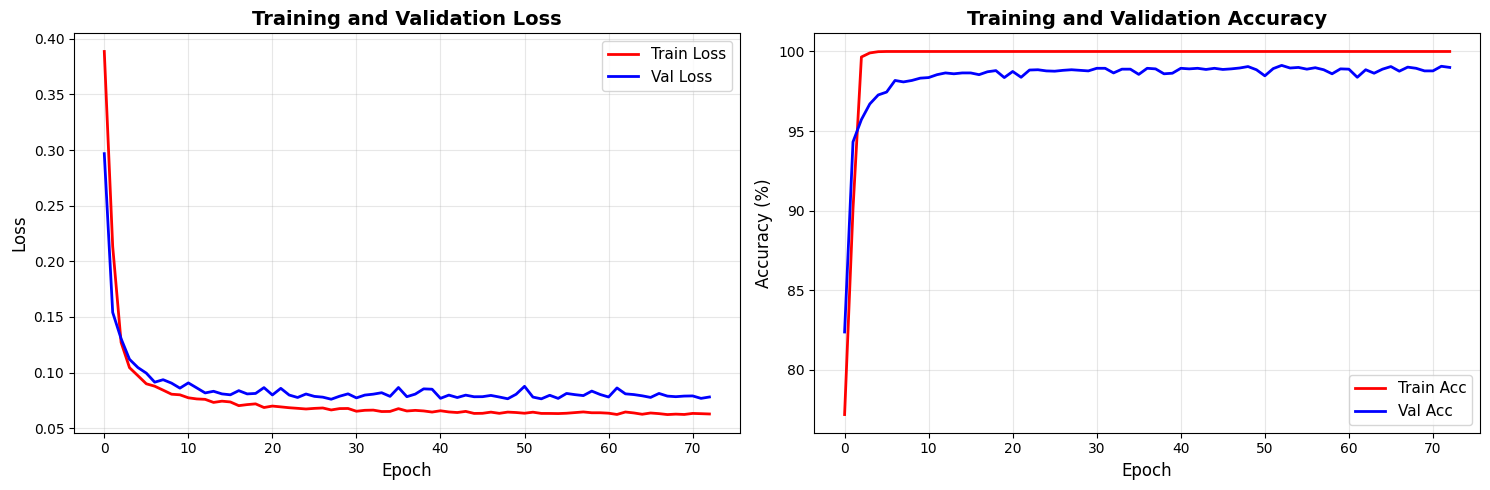

Training history saved to wisdm_training_history.png

FINAL TEST EVALUATION

Classification Report:
              precision    recall  f1-score   support

  Downstairs     0.9392    0.9821    0.9602       503
     Jogging     0.9994    0.9947    0.9971      1710
     Sitting     0.9932    0.9800    0.9866       300
    Standing     0.9796    0.9917    0.9856       242
    Upstairs     0.9782    0.9527    0.9653       613
     Walking     0.9962    0.9972    0.9967      2123

    accuracy                         0.9889      5491
   macro avg     0.9810    0.9831    0.9819      5491
weighted avg     0.9891    0.9889    0.9889      5491



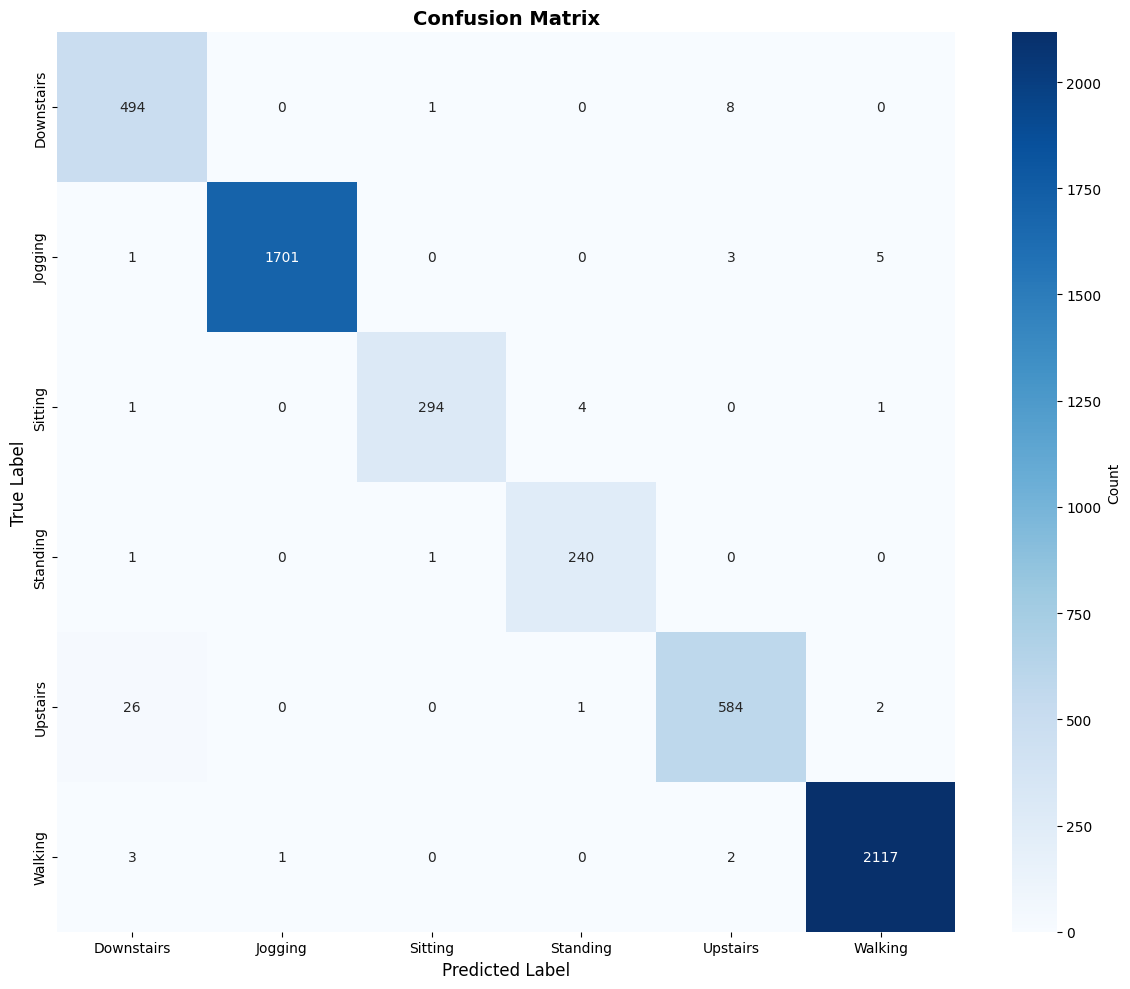

Confusion matrix saved to wisdm_confusion_matrix.png

Extracting features after training...
Computing t-SNE embeddings...


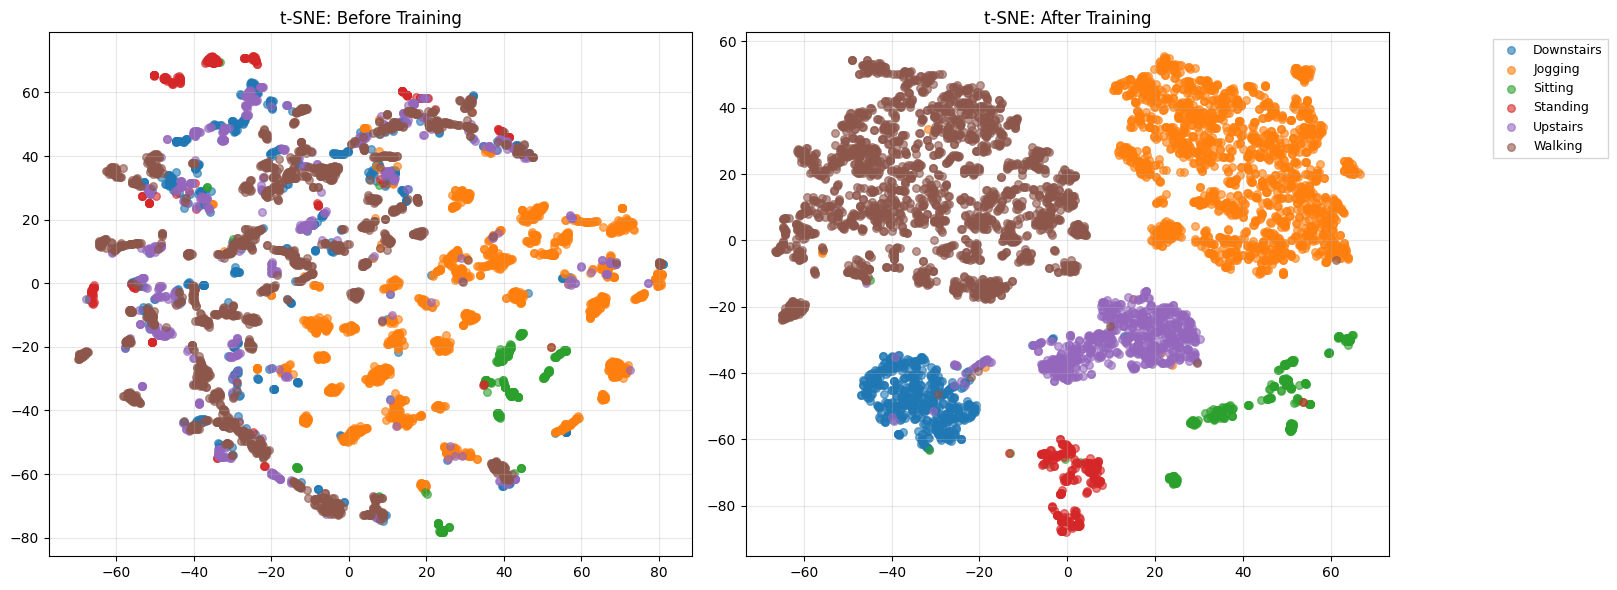

t-SNE visualization saved to wisdm_tsne_comparison.png

PERFORMANCE SUMMARY
Test Accuracy (%)         98.89          
F1 Score (Macro)          0.9819         
Recall (Macro)            0.9831         
Precision (Macro)         0.9810         
Parameters (M)            0.6038         
MACs (M)                  12086.8700     
FLOPs (M)                 24173.7400     
Inference Time (ms)       0.20           

Model parameters: 741,260
Trainable parameters: 741,260
Best Val Acc (%)          99.13          
Best Epoch                53             


In [ ]:
if __name__ == "__main__":
    # Example usage - uncomment and modify as needed:

    # UCI-HAR
    # main(
    #     dataset='uci',
    #     data_path='/path/to/UCI_HAR_Dataset',
    #     num_elk_layers=2,
    #     max_epochs=100
    # )

    # WISDM
    # main(
    #     dataset='wisdm',
    #     data_path='/path/to/WISDM_ar_v1.1_raw.txt',
    #     num_elk_layers=2,
    #     p_shared=6,
    #     max_epochs=100
    # )

    # MHEALTH
    # main(
    #     dataset='mhealth',
    #     data_path='/path/to/MHEALTHDATASET',
    #     num_elk_layers=6,
    #     max_epochs=100
    # )

    # PAMAP2
    # main(
    #     dataset='pamap2',
    #     data_path='/path/to/PAMAP2_integrated_data.csv',
    #     num_elk_layers=2,
    #     p_shared=8,
    #     max_epochs=100
    # )

    main(
        dataset='wisdm',
        data_path='/content/drive/MyDrive/AI_data/WISDM_ar_v1.1_raw.txt'
    )